In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.optimize import minimize
from scipy.optimize import least_squares
import corner
import arviz as az

In [2]:
with open("data.pkl", "rb") as handle:
    data = pkl.load(handle).T

## Problem 1

 Go back to the 11th data set (the last data set) from Problem 2 of Problem Set 2 and sample in the 6-dimensional space (5 linear amplitudes and the period T) with some sensible priors on all 6 parameters (we’ll discuss possible priors in class). Make a “corner plot” of the posterior sampling, and plot a sampling of 16 independent samples from the posterior in the space of the data, on the data.


In [3]:
def gaussian(x, mu, sig):
    return (sig*np.sqrt(2*np.pi))**-1*np.exp(-np.power(x - mu, 2.) / (2 *  np.power(sig, 2.)))

In [4]:
def gaussian1(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 *  np.power(sig, 2.)))

In [5]:
def multigauss(x,mu,sig):
    sig_in = np.linalg.inv(sig)
    expon = -1/2*(x-mu)@sig_in@(x-mu).T
    det_sig = np.linalg.det(sig)
    return (1/(2*np.pi**(len(x)/2)))*(det_sig**(-0.5))*np.exp(expon)

In [6]:
def p_n(x,mu):
    return multigauss(x,mu,np.identity(len(x)))

In [7]:
def prior(x):
    mu = np.array([2.31252804e+00, 2.05420978e+00, 2.87050489e-02, 1.29522484e-01,
       1.93327590e+02, 1.07652299e-03])
    sig = np.diagflat([2.31252804e+00, 2.05420978e+00, 2.87050489e-02, 1.29522484e-01,
       1.93327590e+02, 1.07652299e-03])
    return multigauss(x,mu,sig)

In [8]:
def prob(P,signal):
    prob = np.prod(np.array([gaussian1(i[1],model(P,i[0]),i[2]) for i in signal ]))
    prob*=prior(P)
    return prob

In [9]:
def model(P,x):
    return P[0]*np.sin((2*np.pi/100)*x)+P[1]*np.cos((2*np.pi/100)*x)+P[2]+ P[3]*np.sin((2*np.pi/P[4])*x)+P[5]*np.cos((2*np.pi/P[4])*x)

In [52]:
def model_1sig(P,x):
    return P[0]*np.sin((2*np.pi/100)*x)+P[1]*np.cos((2*np.pi/100)*x)+P[2]

In [25]:
def MH_multi(n,signal):
    ct = 0
    accepts = []
    P0 = np.array([3, 2, 0.05, 0.5,200, 0.01])
    N = len(P0)
    while ct <= n:
        P = np.random.multivariate_normal(P0,np.identity(N))
        r = np.random.uniform()
        if 10**6*prob(P,signal)/prob(P0,signal) > r:
            P0 = P
            accepts.append(P)
            ct+=1
    return np.array(accepts)

We want to find $p(\theta|D,I)$ which is proportional to $p(D|\theta,I)p(\theta|I)$. But $p(D|\theta,I)$ is $\prod_{n =1}^N N(D_n|model(\theta,x_n),\sigma_n)$. And $p(\theta|I)$ is our prior over the parameters without taking the data, which we can set. 

In [26]:
x = data[0]
y = data[-1]
sig = data[1]

In [27]:
signal = np.column_stack([x,y,sig])

In [39]:
b = int(np.floor(np.shape(signal)[0]/32))
signal1 = signal[:b]

In [40]:
prob(np.array([3, 2, 0.05, 0.5,200, 0.01]),signal1)

3.276598262730482e-10

In [42]:
mh = MH_multi(10**3,signal1)

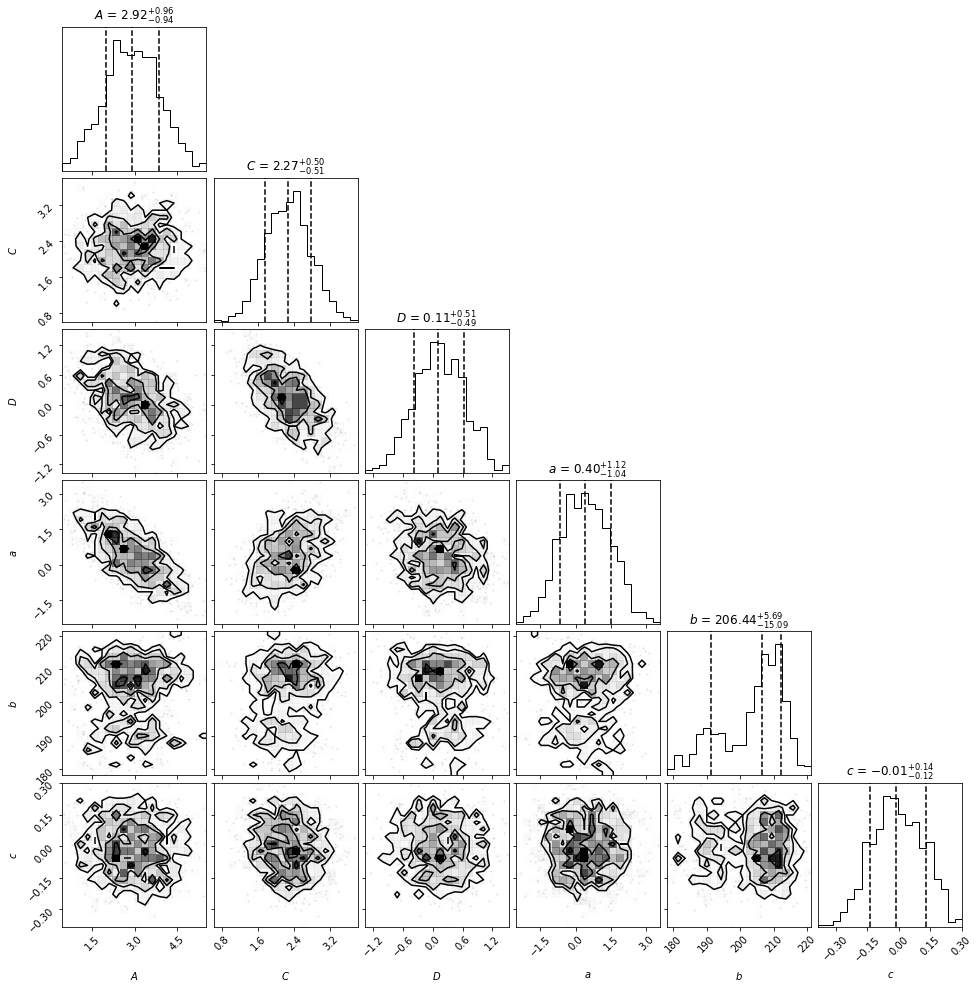

In [44]:
# Plot it.
figure = corner.corner(
    mh,
    labels=[
        r"$A$",
        r"$C$",
        r"$D$",
        r"$a$",
        r"$b$",
        r"$c$",
        r"$d$"
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)#r"$\Gamma \, [\mathrm{parsec}]$"

I excluded a large portion of the signal because I was finding that I was getting 0's because $x^{1024} \approx 0$ when $x < 1$. I dont know what to do about that. But other than that I think the method is fine.

## Problem 2
Plot the residual of the signal in data set 11 mod T, with T the second period.

In [48]:
x = data[0]
y= data[-1]

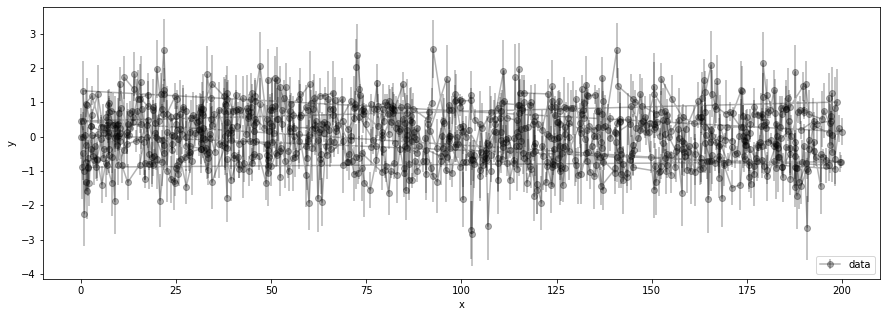

In [67]:
x = data[0]%200
y_test = model_1sig([2.31252804e+00, 2.05420978e+00, 2.87050489e-02],data[0])
y = data[-1]-y_test
plt.figure(figsize=(15, 5))
plt.errorbar(x, y, yerr = data[1], marker = 'o', color = 'k', alpha = 0.3, label='data')
#plt.plot(x_test, y_test, label='fitted model')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='lower right')
plt.show()

This doesn't look so good. If we do it with T = 250 or so though its looks pretty nice. I redid my inital guess for the least squares optimization and closer to T = 250 and it gives T = 256. So that's something.

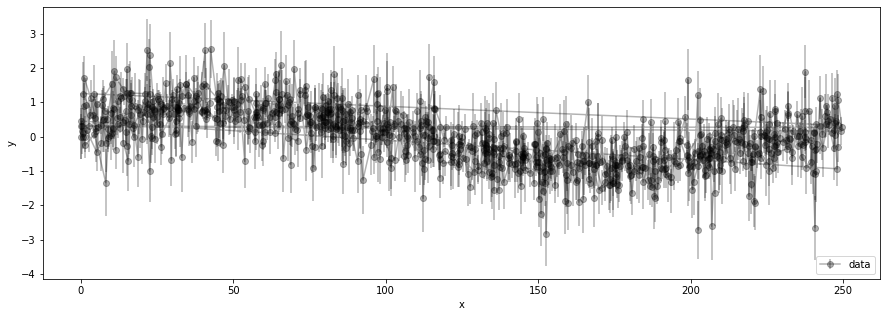

In [68]:
x = data[0]%250
y_test = model_1sig([2.31252804e+00, 2.05420978e+00, 2.87050489e-02],data[0])
y = data[-1]-y_test
plt.figure(figsize=(15, 5))
plt.errorbar(x, y, yerr = data[1], marker = 'o', color = 'k', alpha = 0.3, label='data')
#plt.plot(x_test, y_test, label='fitted model')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='lower right')
plt.show()

## Problem 3
Re-do problem 2 of Problem Set 2 using K-fold cross-validation with K=8. That is, fit the 1- and 2-period models to all but one eighth of each data set and predict the held-out eighth, and repeat for all eight held-out eighths, for all 11 data sets. Which is a better model in each case? Now compute the AIC and BIC instead. Which is a better model according to these? Make a table, maybe?


In [69]:
def fun(P,x,y,C_in):
    return (model(P, x) - y)@C_in@(model(P, x) - y).T

In [120]:
def fun1(P,x,y,C_in):
    return (model1(P, x) - y)@C_in@(model1(P, x) - y).T

In [116]:
def model1(P,x):
    return P[0]*np.sin((2*np.pi/100)*x)+P[1]*np.cos((2*np.pi/100)*x)+P[2]

In [133]:
def k_fold(x,y,c,k):
    subdata = []
    for i in range(k):
        x1, y1, C1 = np.delete(x,np.s_[int(i*(len(x))/k):int((i+1)*(len(x))/k)]), np.delete(y,np.s_[int(i*(len(x))/k):int((i+1)*(len(x))/k)]), np.diagflat(np.delete(C_in,np.s_[int(i*(len(x))/k):int((i+1)*(len(x))/k)]))
        subdata.append([x1,y1,C1])
    return subdata

In [136]:
x = data[0]
C_in = (1/data[1]**2)

In [137]:
super_sub =[]
for i in range(2,13):
    subdata = k_fold(x,data[i],C_in,8)
    super_sub.append(subdata)

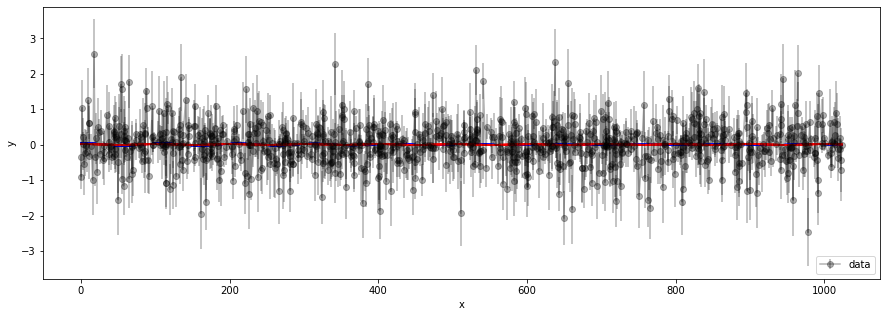

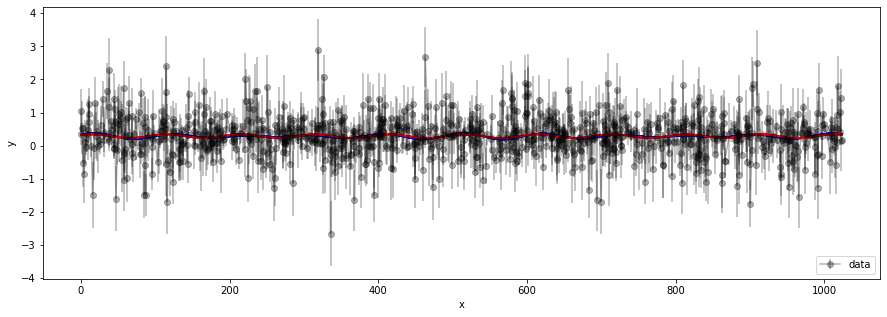

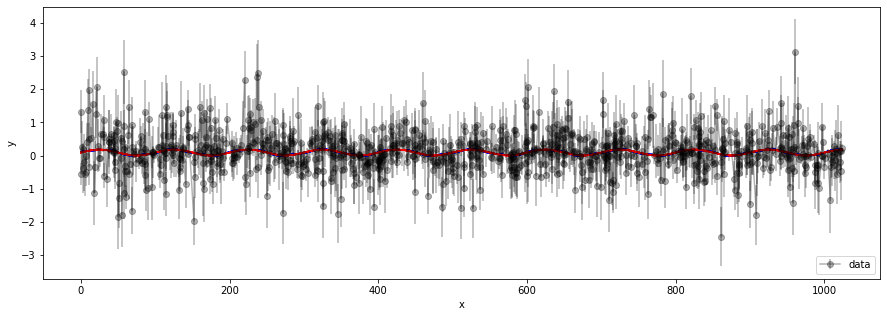

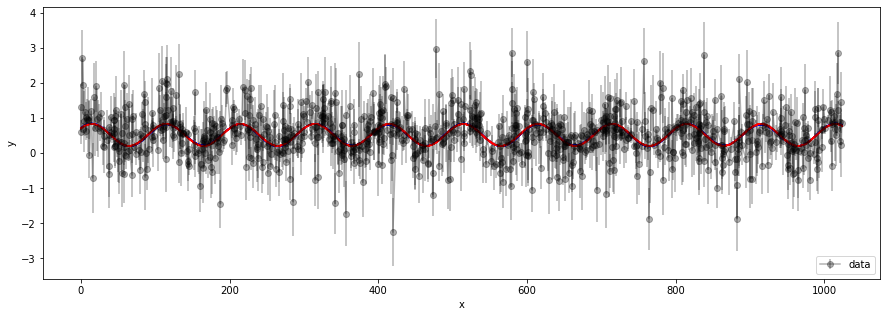

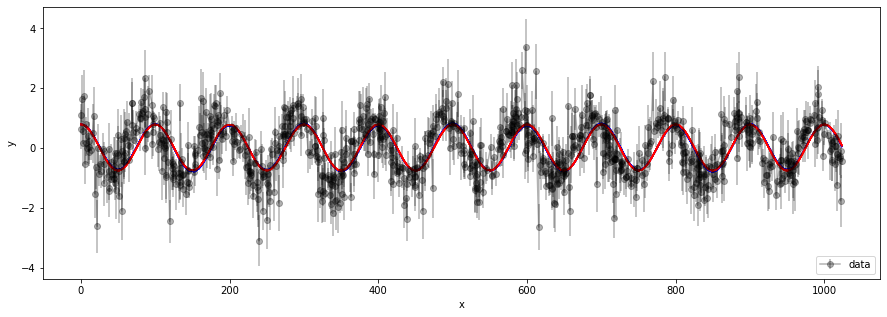

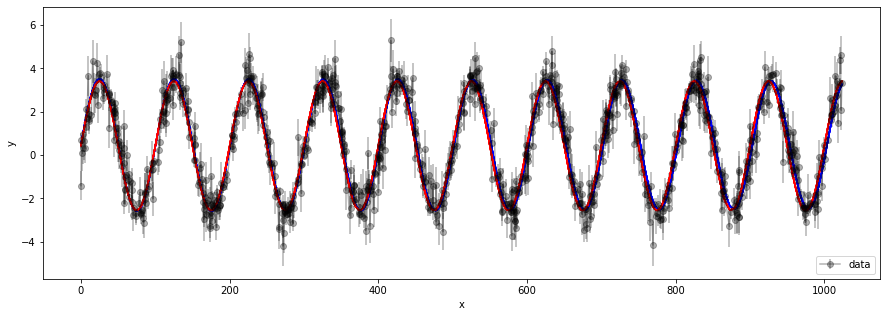

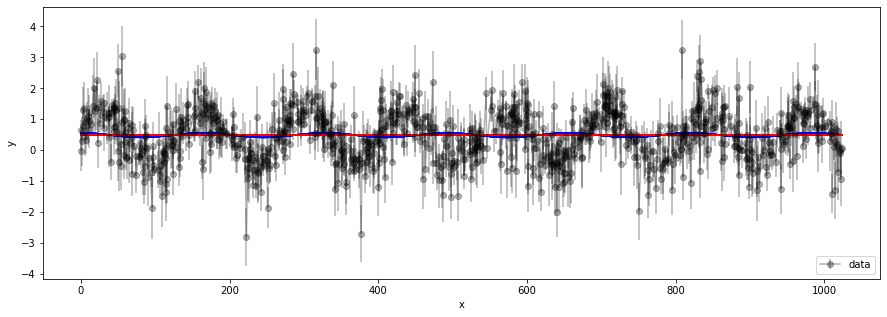

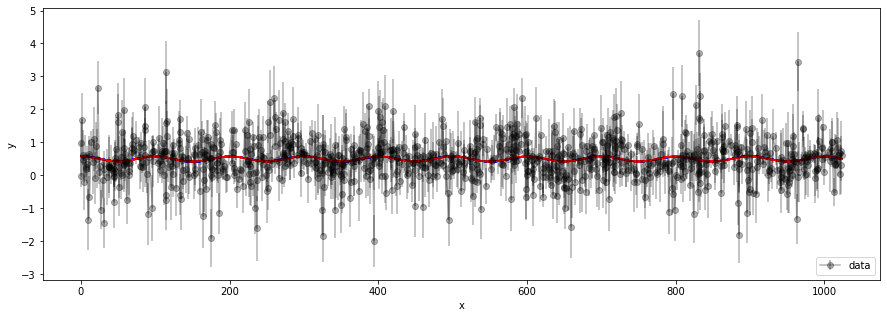

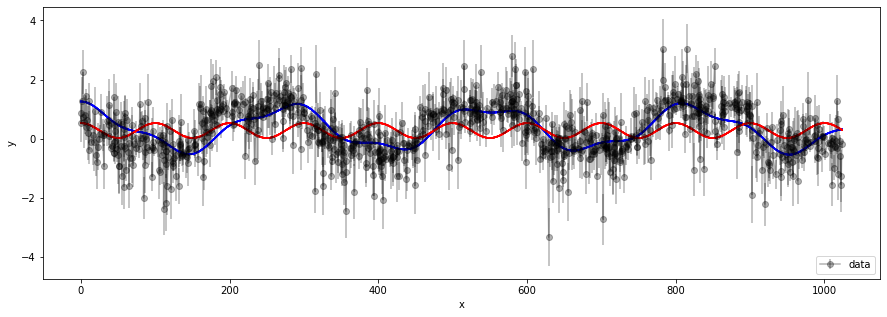

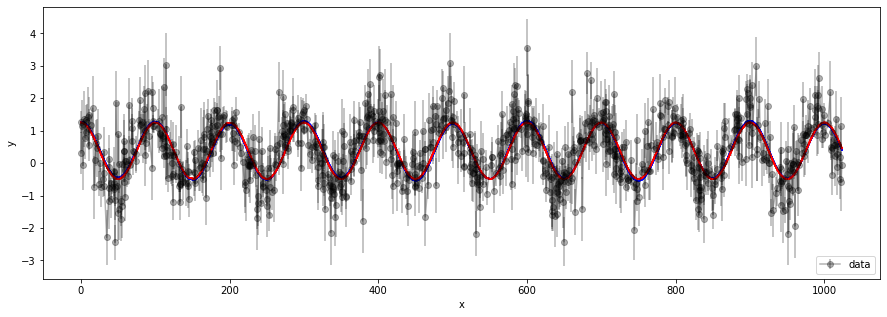

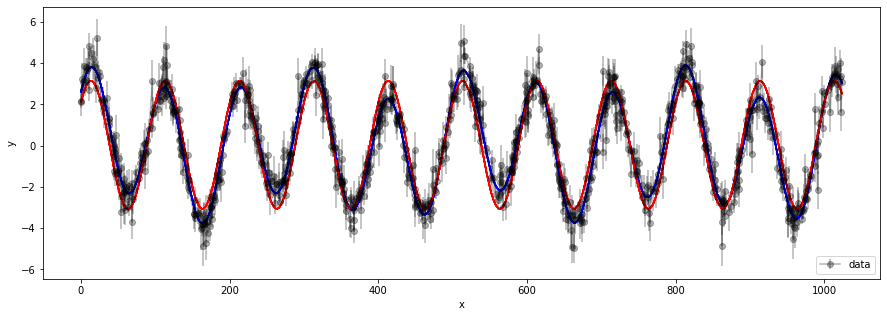

In [147]:
for i in range(2,13):#super_sub:
    k = super_sub[i-2]
    res_0 = []
    res_1 = []
    for j in k:
        x0 = [4,2,2,0.01,250,1]
        res = least_squares(fun, x0, bounds=(0, 500), args = (data[0],data[i],np.diagflat(C_in)))
        res_0.append(res.x)
        x1 = [4,2,2]
        res1 = least_squares(fun1, x1, bounds=(0, 500), args = (data[0],data[i],np.diagflat(C_in)))
        res_1.append(res1.x)
    plt.figure(figsize=(15, 5))
    plt.errorbar(data[0], data[i], yerr = data[1], marker = 'o', color = 'k', alpha = 0.3, label='data')
    for l in res_0:
        plt.plot(data[0],model(l,data[0]), color = 'b')
    for m in res_1:
        plt.plot(data[0],model1(m,data[0]) , color = 'r')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(loc='lower right')
    plt.show()

Compare the Blue (2-signal lines) with the Red (1-signal lines) and you can see that in many cases they agree but in other cases the blue line matches that data more closely. 

Now we will calculate the AIC and BIC for the one and two signal fits.

In [149]:
def AIC(N,log,k):
    return -2/N * log + 2*k/N

In [150]:
def BIC(N,log,k):
    return -2 * log + np.log(N)*k

In [153]:
x = data[0]
C_in = 1/data[1]**2
for i in range(2,13):
        x0 = [4,2,2,0.01,250,1]
        res = least_squares(fun, x0, bounds=(0, 500), args = (x,data[i],np.diagflat(C_in)))
        res_0.append(res.x)
        log_2 = fun(res.x,x,data[i],np.diagflat(C_in))
        x1 = [4,2,2]
        res1 = least_squares(fun1, x1, bounds=(0, 500), args = (x,data[i],np.diagflat(C_in)))
        res_1.append(res1.x)
        log_1 = fun1(res1.x,x,data[i],np.diagflat(C_in))
        print('For data set',i-1,'the one signal AIC = ', AIC(1024,log_1,4),'and BIC =', BIC(1024,log_1,4),'.')
        print('For data set',i-1,'the two signal AIC = ', AIC(1024,log_2,7),'and BIC =', BIC(1024,log_2,7),'.')

For data set 1 the one signal AIC =  -1.9599006592920076 and BIC = -1987.212387892618 .
For data set 1 the two signal AIC =  -1.9505686395291282 and BIC = -1962.861984238631 .
For data set 2 the one signal AIC =  -1.9720891460145078 and BIC = -1999.693398296458 .
For data set 2 the two signal AIC =  -1.9579541613790037 and BIC = -1970.4247586129036 .
For data set 3 the one signal AIC =  -2.006553703210262 and BIC = -2034.9851048649102 .
For data set 3 the two signal AIC =  -1.9980495084316314 and BIC = -2011.4823939947944 .
For data set 4 the one signal AIC =  -2.023277872382357 and BIC = -2052.1106540971355 .
For data set 4 the two signal AIC =  -2.0163514628815618 and BIC = -2030.223595351523 .
For data set 5 the one signal AIC =  -5.8947046271058285 and BIC = -6016.451650933971 .
For data set 5 the two signal AIC =  -5.876337614584987 and BIC = -5982.84941469583 .
For data set 6 the one signal AIC =  -3.911068411798033 and BIC = -3985.208166458788 .
For data set 6 the two signal AIC

In many of these signals (the ones where we suspect there is just one signal), the AIC and BIC hardly change. This is not surprising. Since there are only a few more parameters, You can minimize the log-likelihood enough to offset the penalty from AIC and BIC. Note that some signals (the ones where we suspect that there are in fact multiple signals) have a marked decrease when adding the second signal parameters. This inidicates in some way that the addition of more parameters is valid.